<a href="https://colab.research.google.com/github/AmedeeRoy/BirdAE/blob/main/auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Behavioural Clustering - Deep Autoencoders

This notebook trains a neural network to cluster seabirds behaviours

Networks' characteristics:
- Trajectory window : 60 x 5s
- Output resolution: 60 x 5s
- Representation of trajectories : Matrix Distance and Time series
-    Layers : convolutions




In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

%cd drive/My\ Drive/

Mounted at /content/drive/
/content/drive/My Drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [3]:
data_train = pd.read_table('./data/data_train.csv', sep = ',')
data_test = pd.read_table('./data/data_test.csv', sep = ',')
data_validation = pd.read_table('./data/data_validation.csv', sep = ',')

In [4]:
def dist_ortho(lon1, lat1, lon2, lat2):
    R = 6377726
    pi = np.pi
    a = np.sin((lat1 - lat2)/2*pi/180)**2
    b = np.cos(lat1*pi/180)*np.cos(lat2*pi/180)
    c = np.sin((lon1- lon2)/2* pi/180)**2

    dist = R * 2* np.arcsin( np.sqrt(a + b*c))
    return dist


class TrajDataSet(Dataset):
    def __init__(self,  df, window, transform=None):
        self.df = df.set_index(np.arange(len(df))) #reorder idx
        self.window = window
        self.start_idx = np.where([self.df.trip[i]==self.df.trip[i+self.window-1] for i in range(len(self.df)-self.window+1)])[0]
        self.transform = transform

    def __len__(self):
        return len(self.start_idx)

    def __getitem__(self, idx):

        i = self.start_idx[idx]

        # select variable of interest
        traj = self.df.loc[i:i+self.window-1, ('lon', 'lat')]
        traj = np.array(traj).T

        # select coordinates
        coord = self.df.loc[i:i+self.window-1, ('lon', 'lat')]
        coord = np.array(coord).T
        lon = np.vstack([coord[0] for i in range(traj.shape[1])])
        lat = np.vstack([coord[1]  for i in range(traj.shape[1])])
        dd = dist_ortho(lon, lat, lon.T, lat.T)

        sample = dd

        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        dd = sample
        dd  = torch.FloatTensor(dd)
        return dd.unsqueeze(0)

class Divide(object):
    """Convert ndarrays in sample to Tensors."""

    def __init__(self, ratio):
        self.ratio = ratio
        
    def __call__(self, sample):
        dd = sample
        dd = dd/self.ratio
        return dd


In [5]:
# hyperparameters
window = 128
batch_size = 64

## reduce size dataset
train_set = TrajDataSet(data_train, window, transform = transforms.Compose([Divide(1000), ToTensor()]))
validation_set = TrajDataSet(data_validation, window, transform = transforms.Compose([Divide(1000), ToTensor()]))

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=True)

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.cnn_1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.pooling_1 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 10, stride = 3, padding = 0, dilation = 1)
        )

        self.cnn_2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.pooling_2 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 10, stride = 3, padding = 0, dilation = 1)
        )

        self.cnn_3 = nn.Sequential(
            nn.Conv2d(32, 64,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(64, 128,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )

        self.pooling_3 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 10, stride = 3, padding = 0, dilation = 1)
        )

        self.upsampling_3 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size = 11, stride = 3, padding = 0, dilation = 1)
        )
        
        self.cnn_out_3 = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 64,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(64, 32,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )
        
        self.upsampling_2 = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size = 10, stride = 3, padding = 0, dilation = 1)
        )
        
        self.cnn_out_2 = nn.Sequential(
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 16,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )
        
        self.upsampling_1 = nn.Sequential(
            nn.ConvTranspose2d(8, 8, kernel_size = 11, stride = 3, padding = 0, dilation = 1)
        )
        
        self.cnn_out_1 = nn.Sequential(
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 4, kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU(),
            nn.Conv2d(4, 1,  kernel_size = 5, stride = 1, padding = 2, dilation = 1),
            nn.ReLU()
        )
        
    def forward(self, x):

        out = self.cnn_1(x)
        out = self.pooling_1(out)
        out = self.cnn_2(out)
        out = self.pooling_2(out)
        out = self.cnn_3(out)
        out = self.pooling_3(out)

        out = self.upsampling_3(out)
        out = self.cnn_out_3(out)
        out = self.upsampling_2(out)
        out = self.cnn_out_2(out)
        out = self.upsampling_1(out)
        out = self.cnn_out_1(out)

        return out

In [7]:
# get sample
x = next(iter(train_loader)) 

# Forward model
model = AutoEncoder()

out = model(x)
out.shape

torch.Size([64, 1, 128, 128])

In [8]:
# ## Loss

# def matrixMSE(x, out, alpha):
#   mse = torch.sum((x-out)**2)
#   matrix = torch.sum((torch.transpose(out, 2, 3) - out)**2)

#   return alpha*matrix + (1-alpha)*mse

In [9]:
# Forward model
model = AutoEncoder()
out = model(x)

# Loss and score
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
# matrixMSE(x, out, 0.5)

# send to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

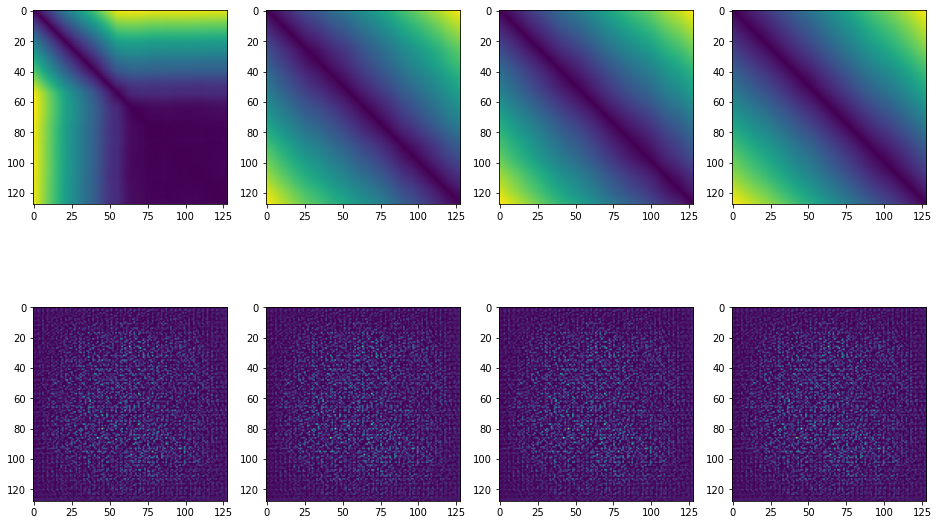

In [10]:
plt.figure(figsize=(16, 10))

# get sample
x = next(iter(train_loader)) 
x= x.to(device)
y = model(x)

for i in range(4):
  X = x[i,0,:,:]
  Y = y[i,0,:,:]
  
  plt.subplot(2,4,i+1)
  plt.imshow(X.cpu().detach().numpy())

  plt.subplot(2,4,i+5)
  plt.imshow(Y.cpu().detach().numpy())

In [11]:
# Train the model
nb_epoch = 5

global_loss_train = []
global_loss_validation = []
    
for epoch in range(nb_epoch):
    i = 0
    for batch, x in enumerate(train_loader):
        i+=1
        # send to GPU
        x= x.to(device)

        # Run the forward pass
        out = model(x)
        loss = criterion(out, x)
        
        # Backprop and perform optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    ### Evaluation + Validation every epoch
    model.eval()
    with torch.no_grad():      
        j = 0
        # evaluation
        list_loss_train = []
        list_score_train = []
        for batch, x in enumerate(train_loader):
            j+= 1
            # send to GPU
            x= x.to(device)
            # Run the forward pass
            out = model(x)
            loss = criterion(out, x)
            list_loss_train.append(loss.item())
        
        train_loss = np.mean(list_loss_train)
            
        k = 0
        # validation
        list_loss_validation = []
        for batch, x in enumerate(validation_loader):
            k+= 1
             # send to GPU
            x= x.to(device)
            # Run the forward pass
            out = model(x)
            loss = criterion(out, x)
            list_loss_validation.append(loss.item())

        validation_loss = np.mean(list_loss_validation)

    print('Epoch [{}/{}] ------------------------------------------------------'
          .format(epoch+1, nb_epoch))
    print('Train Loss: {}'
            .format(round(train_loss, 2)))
    print('Validation Loss: {}'
            .format(round(validation_loss, 2)))
    model.train()
    
    global_loss_train.append(train_loss)
    global_loss_validation.append(validation_loss)

    #### STOP WHEN VALIDATION DECREASE
    if epoch>1:
        if global_loss_validation[-2] < global_loss_validation[-1]:
            break

Epoch [1/5] -------------------------------------------------------------------------------------
Train Loss: 0.0
Validation Loss: 0.0
Epoch [2/5] -------------------------------------------------------------------------------------
Train Loss: 0.0
Validation Loss: 0.0


KeyboardInterrupt: ignored

11.956327
4.9757414
17.38894
10.055641


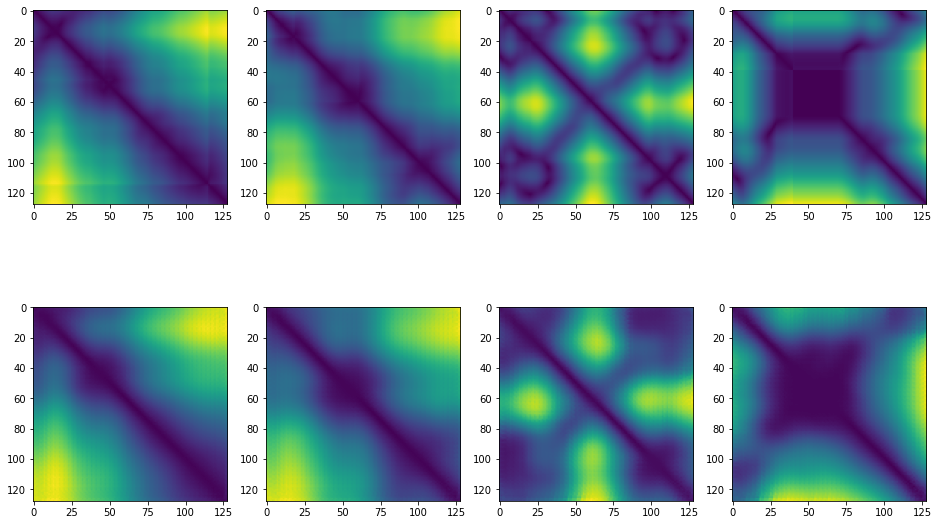

In [14]:
plt.figure(figsize=(16, 10))

# get sample
x = next(iter(train_loader)) 
x= x.to(device)
y = model(x)

for i in range(4):
  X = x[i,0,:,:].cpu().detach().numpy()
  Y = y[i,0,:,:].cpu().detach().numpy()
  
  print(np.sum((X-Y)**2))

  plt.subplot(2,4,i+1)
  plt.imshow(X)

  plt.subplot(2,4,i+5)
  plt.imshow(Y)